<a href="https://colab.research.google.com/github/robpalinic/Springboard-Projects/blob/main/Take_Home_Ultimate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ultimate Take Home Challenge**

**Data description**

*   city: city this user signed up in
*   phone: primary device for this user
*   signup_date: date of account registration; in the form ‘YYYYMMDD’
*   last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’
*   avg_dist: the average distance in miles per trip taken in the first 30 days after signup
*   avg_rating_by_driver: the rider’s average rating over all of their trips
*   avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
*   surge_pct: the percent of trips taken with surge multiplier > 1
*   avg_surge: The average surge multiplier over all of this user’s trips
*   trips_in_first_30_days: the number of trips this user took in the first 30 days signing up
*   ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
*   weekday_pct: the percent of the user’s trips occurring during a weekday


---




In [259]:
#Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, plot_roc_curve
from collections import defaultdict

In [260]:
#Read in both files

ultimate_download = open('/content/drive/MyDrive/Ultimate_challenge/ultimate_data_challenge.json')
ultimate = pd.DataFrame(json.load(ultimate_download))
logins_download = open('/content/drive/MyDrive/Ultimate_challenge/logins.json')
logins = pd.DataFrame(json.load(logins_download))

In [261]:
#Investigate the ultimate_data_challenge.json file

ultimate.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [262]:
#Investigate the logins.json file

logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21




---


### **Part 1:  Exploratory Data Analysis**

The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [263]:
#Determine number of records

logins.shape

(93142, 1)

In [264]:
#Identify minimum and maximum dates in the file

print(logins.login_time.min())
print(logins.login_time.max())

1970-01-01 20:12:16
1970-04-13 18:57:38


In [265]:
#Aggregate logins by time, with 15 minute intervals

#Remove Dates from the Datetime portion
logins.index = pd.to_datetime(logins.index)
logins['login_time'] = pd.to_datetime(logins['login_time'])
logins['time'] = logins['login_time'].dt.strftime('%H:%M:%S')
logins = logins.set_index(pd.DatetimeIndex(logins['login_time']))
login_times= pd.DataFrame(list(logins['time']))

#Add a record copunter for each login
login_times['Records'] = 1
login_times.rename(columns={0:'Time', 'Records':'Logins'}, inplace=True)

#Aggregate in 15 minute intervals
login_times['Time'] = pd.to_datetime(login_times['Time'])
login_times = login_times.set_index('Time')
login_intervals = login_times.resample('15T').sum()

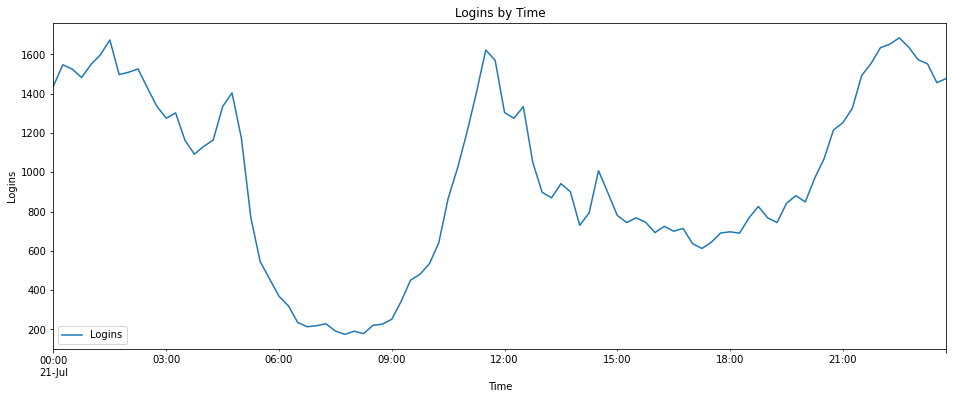

In [266]:
#Plot login counts by time

login_intervals.plot(title='Logins by Time', ylabel = 'Logins', figsize=(16,6));

**Part 1 Conclusions:**
1.  The data provided for logins was complete in terms of time of day, but had issues regarding dats, namely that the date range was from January 1970 to April 1970.  This indicates issues with data formatting that would need to be corrected.
2.  There are four periods throughout the day.  
  a. From roughly 9 pm to 5 am is a peak period in terms of logins, and is the busiest overall time of day for drivers.  
  b. Secondly is 5 am to 9 am, when there is next to no demand.  
  c. Period three is from 9 am to 1 pm, where demand picks up again and has a sharp maximum at 12 pm.  
  d. Finally, from 1 pm to 8 pm is a moderately busy time, not as high as the midnight or noon peaks, but also not as low as the early morning.



---


### **Part 2 : Experiment and metrics design**
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.



**1**. **What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?**

I would chose average distance as the key metric.  The goal of the program is to encourage driver partners to drive to both cities, and the best measure of this with the data available will be distance travelled.  Longer distances would indicate that the program is working.



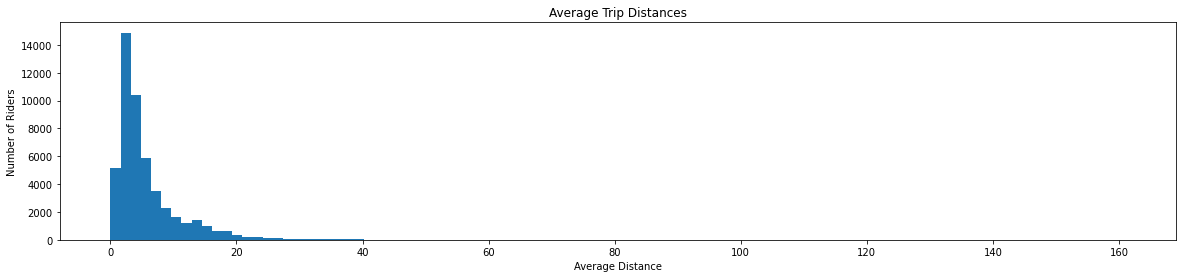

In [267]:
#Visualize Average Trip Distance by Rider


plt.figure(figsize=(20, 4))
plt.hist(ultimate.avg_dist, bins=100)
plt.xlabel('Average Distance')
plt.ylabel('Number of Riders')
plt.title('Average Trip Distances');

In [268]:
print("The average of riders' average trip distance is: " + str(round(np.mean(ultimate.avg_dist), 2)) + " miles.")

The average of riders' average trip distance is: 5.8 miles.


**2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.**


A practical experiment  would do is to announce a 'toll-free week', where all tolls would be waved and trips would be cheaper between the two cities.  This could be marketed as a celebration of the company's anniversary, or solar equinox, or any other excuse.  Awareness is key for both driver partners and passengers.

Following the week, analysis can be performed on the average distance metric and a t-test used to compare against previous patterns, to indicate if distances have increased or are the same. This can and should be broken down into date and time periods to identify if only certain periods are affected.

If there is a statistically significant difference in distances, we could conlude that the toll reduction has resulted in driver partners travelling more between the two cities.  We could also pinpoint when the toll reduction is most impactful and whether it should be time based or a blanket reduction.

The only caveat is that the awareness of a free week may have changed behaviours.  A second test without fanfare may be useful to confirm actual changes.


---



### **Part 3 ‐ Predictive modeling**
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.




**1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?**

In [269]:
ultimate.shape

(50000, 12)

In [270]:
#Identify when riders signed up
print(ultimate['signup_date'].min())
print(ultimate['signup_date'].max())

#Confirmed that only in January

2014-01-01
2014-01-31


In [271]:
#Identify the last trip

print(ultimate['last_trip_date'].max())

#Confirmed that data ends July 1st.

2014-07-01


In [272]:
#How many riders made it to the six month total?
ultimate[ultimate['last_trip_date']>='2014-06-01']['phone'].count()

18671

In [273]:
#How many riders did not make it to the six month total?
ultimate[ultimate['last_trip_date']<'2014-06-01']['phone'].count()

30933

Out of 50k riders, 31k churned, roughly 62% of riders.

In [274]:
#Add a churn flag

ultimate['churn'] = np.where(ultimate['last_trip_date']<'2014-06-01', 1, 0)

In [275]:
#Remove unneeded fields:  signup_date, last_trip_date, phone

ultimate.drop(columns=['signup_date', 'last_trip_date', 'phone'], axis=1, inplace=True)
ultimate.head()

,city,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,churn
0,King's Landing,4,4.7,1.10,15.4,True,46.2,3.67,5.0,0
1,Astapor,0,5.0,1.00,0.0,False,50.0,8.26,5.0,1
2,Astapor,3,4.3,1.00,0.0,False,100.0,0.77,5.0,1
3,King's Landing,9,4.6,1.14,20.0,True,80.0,2.36,4.9,0
4,Winterfell,14,4.4,1.19,11.8,False,82.4,3.13,4.9,1


In [276]:
#Deal with NaN

ultimate.isnull().sum()

city                         0
trips_in_first_30_days       0
avg_rating_of_driver      8122
avg_surge                    0
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
churn                        0
dtype: int64

In [277]:
#Two fields have missing data.  This data can be removed
ultimate.dropna(inplace=True)
ultimate.shape

(41744, 10)

In [278]:
#Identify Outliers
ultimate.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,churn
count,41744.000000,41744.000000,41744.000000,41744.000000,41744.000000,41744.000000,41744.000000,41744.000000
mean,2.611393,4.601801,1.073697,8.884695,61.304437,5.465312,4.776648,0.588971
std,4.060121,0.616079,0.198681,18.309042,34.799944,5.149810,0.404109,0.492026
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,4.300000,1.000000,0.000000,37.500000,2.420000,4.700000,0.000000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.790000,5.000000,1.000000
75%,3.000000,5.000000,1.070000,11.100000,100.000000,6.490000,5.000000,1.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,79.690000,5.000000,1.000000


Trips in First 30 days has a max value of 125, for an average of 4 trips a day.  It is possible, as someone is going to work, going home, then going out, maybe bar hopping, so we will keep the data.  

The maximum for average distance is 79.69.  A person might be using this service for inter-city travel, so this data is plausible.

All the data looks good, no changes needed.

In [279]:
#City needs to be one hot encoded to numerical fields

ultimate = pd.get_dummies(ultimate, drop_first = True)
ultimate.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,churn,city_King's Landing,city_Winterfell
0,4,4.7,1.10,15.4,True,46.2,3.67,5.0,0,1,0
1,0,5.0,1.00,0.0,False,50.0,8.26,5.0,1,0,0
2,3,4.3,1.00,0.0,False,100.0,0.77,5.0,1,0,0
3,9,4.6,1.14,20.0,True,80.0,2.36,4.9,0,1,0
4,14,4.4,1.19,11.8,False,82.4,3.13,4.9,1,0,1


In [280]:
#ultimate_black_user will be changed from True/False to 1/0

ultimate['ultimate_black_user'] = ultimate['ultimate_black_user'].replace([True, False], [1,0])
ultimate.head()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,churn,city_King's Landing,city_Winterfell
0,4,4.7,1.10,15.4,1,46.2,3.67,5.0,0,1,0
1,0,5.0,1.00,0.0,0,50.0,8.26,5.0,1,0,0
2,3,4.3,1.00,0.0,0,100.0,0.77,5.0,1,0,0
3,9,4.6,1.14,20.0,1,80.0,2.36,4.9,0,1,0
4,14,4.4,1.19,11.8,0,82.4,3.13,4.9,1,0,1


In [281]:
#All data needs to be set to the same scale

y = ultimate['churn']
X = ultimate.drop(columns='churn', axis=1)

columns = X.columns
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=columns)
X.shape


(41744, 10)

We now have 41,744 records and 10 fields to use for model development, in a variable 'X'.  Target variable 'y' is a flag for churned customers.



---




**2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.**

This case calls for a Logistic Regression model, to predict a binary outcome (churn or not churn).  This is a straightforward model that can also be easily explained to a non-technical audience.  I decided not to use a Random Forest model, which may have a slightly higher degree of accuracy, as it will essentially be a black box that will have a harder time of getting buy in from business partners.

The major concern I have is the incompleteness of the data.  We are defining churn as not active in the 6th month, but an occasional user  may only use the service every two months.  I personally only use such services when I travel, and so would be considerd churn.  Also, we do not know how these users signed up, and whether it was promotionally driven or not, as that would be a major flag of future churn.

In [282]:
#Create and train the Logistics Regression Model

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.3)
lr = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = lr.predict(X_test)


In [283]:
#Provide a score for the model

roc_auc_score(y_test, y_pred)

0.6586931543798542

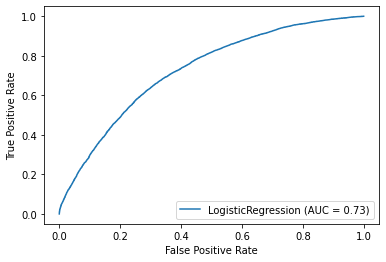

In [284]:
#Graphically show the model's accuracy in predicting churn.
plot_roc_curve(lr, X_test, y_test);

In [285]:
#Find the coefficients of each feature, with higher absolute numbers indicating higher importance.

feature_importance = defaultdict(float)
columns = np.array(columns)
for i in range(0, 10):
  feature_importance[columns[i]] = round(lr.coef_[0][i], 2)

feature_importance

defaultdict(float,
            {'avg_dist': 0.21,
             'avg_rating_by_driver': 0.11,
             'avg_rating_of_driver': 0.05,
             'avg_surge': 0.05,
             "city_King's Landing": -0.7,
             'city_Winterfell': -0.26,
             'surge_pct': -0.09,
             'trips_in_first_30_days': -0.46,
             'ultimate_black_user': -0.46,
             'weekday_pct': 0.01})

In [286]:
#Providee a list of least important to most important features.

sorted(feature_importance, key=feature_importance.get)

["city_King's Landing",
 'trips_in_first_30_days',
 'ultimate_black_user',
 'city_Winterfell',
 'surge_pct',
 'weekday_pct',
 'avg_rating_of_driver',
 'avg_surge',
 'avg_rating_by_driver',
 'avg_dist']

The ROC score of .66 indicates that the model is fairly accurate, but not a perfect predictor.  Directionally it is useful, but would have trouble identifyin g individuals who are about to churn.
The three most important features are whether riders are residents of King's Landing (followed by Winterfell residents), whether they are Ultimate Black users, and the number of trips in the first 30 days. This translates into higher churn for Astapor residents, and those who do not use Ultimate Black or have a high number of trips.


**3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long­term rider retention (again, a few sentences will suffice).**

Of the three identified features, residency is the most actionable.  Ultimate Black Users and those who used the service a lot in the first 30 days can not be influenced as they clearly already made up their minds as to the service.  But for some reason Astapor residents have a propensity to churn.  Investigation would need to be undertaken.  Are the market conditions different, with other competitors?  Is traffic notoriously bad?  Is there a tool bridge causing higher prices?  Either way, there clearly exists a major difference between Astapor and King's Landing/Winterfell that is causing churn.